In [2]:
# Mount Google Drive locally
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the datset into a pandas dataframe
from joblib import load

data = load("/content/drive/MyDrive/mortgage_data_preprocess.pkl.gz")

X = data[0]
y = data[1]

# Concatonate the data into a dataframe
import pandas as pd

df = pd.concat([X, y], axis=1)

In [4]:
df

,loan_amount_000s,applicant_income_000s,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,applicant_ethnicity_name_Hispanic or Latino,applicant_ethnicity_name_Not Hispanic or Latino,applicant_race_name_1_American Indian or Alaska Native,applicant_race_name_1_Asian,applicant_race_name_1_Black or African American,applicant_race_name_1_Native Hawaiian or Other Pacific Islander,applicant_race_name_1_White,applicant_sex_name_Female,applicant_sex_name_Male,agency_abbr_CFPB,agency_abbr_FDIC,agency_abbr_FRS,agency_abbr_HUD,agency_abbr_NCUA,agency_abbr_OCC,owner_occupancy_name_Not applicable,owner_occupancy_name_Not owner-occupied as a principal dwelling,owner_occupancy_name_Owner-occupied as a principal dwelling,property_type_name_Manufactured housing,property_type_name_One-to-four family dwelling (other than manufactured housing),loan_purpose_name_Home improvement,loan_purpose_name_Home purchase,loan_purpose_name_Refinancing,loan_type_name_Conventional,loan_type_name_FHA-insured,loan_type_name_FSA/RHS-guaranteed,loan_type_name_VA-guaranteed,action_taken_name
0,102,151.0,5972.0,1.890000,66600.0,106.129997,1973.0,2194.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,False
1,114,30.0,4188.0,4.660000,49500.0,106.169998,1331.0,3113.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,False
2,105,112.0,9565.0,42.529999,61200.0,100.330002,2504.0,3149.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,False
3,270,182.0,5928.0,9.990000,67400.0,170.520004,1755.0,2102.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,False
4,62,36.0,4021.0,3.560000,54200.0,139.789993,1296.0,1487.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,85,29.0,2930.0,2.830000,62800.0,130.320007,904.0,1021.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,True
199996,1400,332.0,4732.0,9.780000,84200.0,135.429993,986.0,2642.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,True
199997,5,60.0,4301.0,47.220001,84500.0,52.560001,446.0,1211.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,True
199998,95,50.0,6101.0,7.330000,52700.0,93.489998,1633.0,2554.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,True


In [5]:
# install AIF360
!pip install aif360

     |████████████████████████████████| 174kB 11.8MB/s 


In [6]:
# Instantiate the classifier
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=10, solver="lbfgs", penalty="none")

# instantiate the cross-validation scheme
folds = 10
from sklearn.model_selection import StratifiedKFold
mv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=10)

# setup the performance metrics to be computed
from sklearn import metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
                }

# Set up the fairness metrics to be computed using AIF360
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

privileged_group = [{'applicant_sex_name_Female': 0}] 
unprivileged_group = [{'applicant_sex_name_Female': 1}]

In [7]:
# Tune the threshold using 10 fold cross validation

thresholds = [0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7]
import pandas as pd
import numpy as np
k, i = True, 0

# instantiating X
X = df.drop(labels=df.columns[-1], axis=1)

# instantiating the target variable
y = df[df.columns[-1]]

for fold_threshold in thresholds:
  av_f1 = 0
  av_acc = 0
  av_auc = 0
  av_precision = 0
  av_recall = 0
  av_statpar = 0
  av_av_odds = 0


  for (train, test) in mv.split(X, y):

      # fit model
      lr = lr.fit(X.iloc[train], y.iloc[train].values.ravel())
      
      # get predictions in the test set
      ypred_prob = lr.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
      ypred_class = np.where(ypred_prob > fold_threshold, 1, 0)

      # compute performance metrics
      metrics = []
      metrics += [['Threshold', fold_threshold]]
      dataset = X.iloc[test].copy()
      dataset[df.columns[-1]] = np.expand_dims(y.iloc[test], axis=1)
      dataset = BinaryLabelDataset(df=dataset, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])
      dataset_pred = X.iloc[test].copy()
      dataset_pred[df.columns[-1]] = np.expand_dims(ypred_class, axis=1)
      dataset_pred = BinaryLabelDataset(df=dataset_pred, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])
      metric_CM = ClassificationMetric(dataset, dataset_pred, privileged_groups=privileged_group, unprivileged_groups=unprivileged_group)

      av_f1 += perf_metrics["F1-Score"](y.iloc[test].values.ravel(), ypred_class)
      av_acc += perf_metrics["Accuracy"](y.iloc[test].values.ravel(), ypred_class)
      av_auc += perf_metrics["AUC"](y.iloc[test].values.ravel(), ypred_class)
      av_precision += perf_metrics["Precision"](y.iloc[test].values.ravel(), ypred_class)
      av_recall += perf_metrics["Recall"](y.iloc[test].values.ravel(), ypred_class)
      av_statpar = metric_CM.statistical_parity_difference()
      av_av_odds = metric_CM.average_odds_difference()

    
  # Compute fairness metrics
  metrics += [['Threshold', fold_threshold]]
  metrics += [['F1', av_f1/folds]]
  metrics += [['Accuracy', av_acc/folds]]
  metrics += [['AUC', av_auc/folds]]
  metrics += [['Precision', av_precision/folds]]
  metrics += [['Recall', av_recall/folds]]
  metrics += [['Statistical Parity Difference', av_statpar/folds]]
  metrics += [['Average Odds Difference', av_av_odds/folds]]


  # concatenate results
  df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
  df_m["Fold"] = i
  i += 1
  if k:
      df_metrics = df_m.copy()
      k=0
  else:
      df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [8]:
# Display metrics
df_pivot = df_metrics.pivot_table(index="Fold", columns="Metric")["Value"]
df_pivot

Metric,AUC,Accuracy,Average Odds Difference,F1,Precision,Recall,Statistical Parity Difference,Threshold
Fold,,,,,,,,
0,0.500550,0.500550,0.000530,0.665754,0.500277,0.99481,0.000527,0.30
1,0.507825,0.507825,0.002173,0.662070,0.504098,0.96428,0.002207,0.40
2,0.534260,0.534260,0.007271,0.643755,0.521353,0.84217,0.007520,0.45
3,0.552310,0.552310,0.010899,0.497357,0.566818,0.44344,0.011595,0.50
4,0.533340,0.533340,0.002823,0.269125,0.619862,0.17314,0.003136,0.55
5,0.516235,0.516235,0.000036,0.118985,0.653371,0.06618,0.000074,0.60
6,0.500155,0.500155,-0.000031,0.003525,0.548654,0.00177,-0.000032,0.70


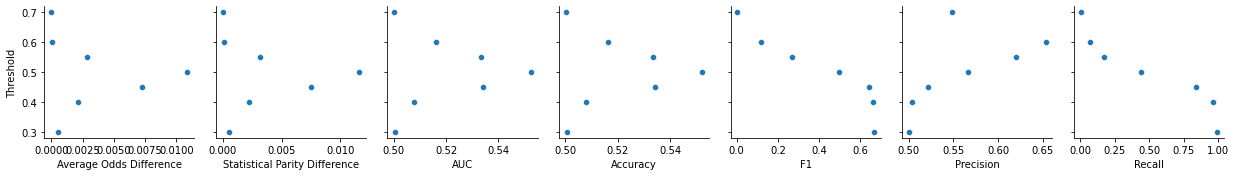

In [9]:
# Plot metrics against the threshold values
import seaborn as sns
y_vars = ['Threshold']
x_vars = ['Average Odds Difference', 'Statistical Parity Difference', 'AUC', 'Accuracy', 'F1', 'Precision', 'Recall']

g = sns.PairGrid(df_pivot, x_vars=x_vars, y_vars=y_vars)
g.map(sns.scatterplot)

Re-run post-processing from Part 3 with two different classification thresholds.

In [10]:
# Instantiate the classifier
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=10, solver="lbfgs", penalty="none")

# instantiate the cross-validation scheme
folds = 10
from sklearn.model_selection import StratifiedKFold
mv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=10)

# setup the performance metrics to be computed
from sklearn import metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
                }

# Set up the fairness metrics to be computed using AIF360
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

privileged_group = [{'applicant_sex_name_Female': 0}] 
unprivileged_group = [{'applicant_sex_name_Female': 1}]

In [11]:
from aif360.algorithms.postprocessing import EqOddsPostprocessing

# Learn parameters to equalize odds and apply to create a new dataset
epp = EqOddsPostprocessing(privileged_groups = privileged_group,
                                     unprivileged_groups = unprivileged_group,
                                     seed=42)


In [12]:
# Train a logistic regression classifier with two different thresholds

thresholds = [0.45, 0.5]
import pandas as pd
import numpy as np
k, i = True, 0

# instantiating X
X = df.drop(labels=df.columns[-1], axis=1)

# instantiating the target variable
y = df[df.columns[-1]]

for fold_threshold in thresholds:
  av_f1 = 0
  av_acc = 0
  av_auc = 0
  av_precision = 0
  av_recall = 0
  av_statpar = 0
  av_av_odds = 0

  for (train, test) in mv.split(X, y):

      # fit model
      lr = lr.fit(X.iloc[train], y.iloc[train].values.ravel())
      
      # get predictions in the test set
      ypred_prob = lr.predict_proba(X.iloc[test]).ravel()[1::2] # get probabilities
      ypred_class = np.where(ypred_prob > fold_threshold, 1, 0)
      y_test = y.iloc[test]
      X_test = X.iloc[test]

      # fit post-processing using results from 60% of the test set
      test_pct = 0.4
      n = int(len(y_test))
      n_2 = int(n* (1-test_pct))
      indices = np.random.permutation(n)
      pp_indices = indices[:n_2]
      test_indices = indices[n_2:]

      pp_dataset = X_test.iloc[pp_indices].copy()
      pp_dataset[df.columns[-1]] = np.expand_dims(y_test.iloc[pp_indices], axis=1)
      pp_dataset_BLD = BinaryLabelDataset(df=pp_dataset, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])

      pp_pred = X_test.iloc[pp_indices].copy()
      pp_pred[df.columns[-1]] = np.expand_dims(ypred_class[pp_indices], axis=1)
      pp_pred_BLD = BinaryLabelDataset(df=pp_pred, label_names=[df.columns[-1]], protected_attribute_names=['applicant_sex_name_Female'])

      epp = epp.fit(pp_dataset_BLD, pp_pred_BLD)

      # Use epp to post-process predictions on the other 40% of the test set
      actuals_test = X_test.iloc[test_indices].copy()
      actuals_test[df.columns[-1]] = np.expand_dims(y_test.iloc[test_indices], axis=1)
      actuals_test_BLD = BinaryLabelDataset(df=actuals_test, label_names=['action_taken_name'], protected_attribute_names=['applicant_sex_name_Female'])
      pred_test = X_test.iloc[test_indices].copy()
      pred_test[df.columns[-1]] = np.expand_dims(ypred_class[test_indices], axis=1)
      pred_test_BLD = BinaryLabelDataset(df=pred_test, label_names=[df.columns[-1]], protected_attribute_names=['applicant_sex_name_Female'])

      transf_pred_test_BLD = epp.predict(pred_test_BLD)

      # compute performance metrics
      metrics = []
      metrics += [['Threshold', fold_threshold]]
      metric_CM = ClassificationMetric(actuals_test_BLD, transf_pred_test_BLD, privileged_groups=privileged_group, unprivileged_groups=unprivileged_group)

      av_f1 += perf_metrics["F1-Score"](y.iloc[test].values.ravel(), ypred_class)
      av_acc += perf_metrics["Accuracy"](y.iloc[test].values.ravel(), ypred_class)
      av_auc += perf_metrics["AUC"](y.iloc[test].values.ravel(), ypred_class)
      av_precision += perf_metrics["Precision"](y.iloc[test].values.ravel(), ypred_class)
      av_recall += perf_metrics["Recall"](y.iloc[test].values.ravel(), ypred_class)
      av_statpar = metric_CM.statistical_parity_difference()
      av_av_odds = metric_CM.average_odds_difference()

    
  # Compute fairness metrics
  metrics += [['Threshold', fold_threshold]]
  metrics += [['F1', av_f1/folds]]
  metrics += [['Accuracy', av_acc/folds]]
  metrics += [['AUC', av_auc/folds]]
  metrics += [['Precision', av_precision/folds]]
  metrics += [['Recall', av_recall/folds]]
  metrics += [['Statistical Parity Difference', av_statpar/folds]]
  metrics += [['Average Odds Difference', av_av_odds/folds]]


  # concatenate results
  df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
  df_m["Fold"] = i
  i += 1
  if k:
      df_metrics = df_m.copy()
      k=0
  else:
      df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: Co

In [13]:
# Display metrics
df_pivot = df_metrics.pivot_table(index="Fold", columns="Metric")["Value"]
df_pivot

Metric,AUC,Accuracy,Average Odds Difference,F1,Precision,Recall,Statistical Parity Difference,Threshold
Fold,,,,,,,,
0,0.53426,0.53426,-0.000987,0.643755,0.521353,0.84217,-0.000773,0.45
1,0.55231,0.55231,-0.001677,0.497357,0.566818,0.44344,-0.001032,0.50


The model that minimises false-negatives is the model with a threshold of 0.45.